In [1]:
import pandas as pd
import cv2
import os
import numpy as np

from skimage.io import imread, imsave
from skimage.transform import resize
import tensorflow as tf
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split

2024-03-03 14:08:45.752766: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-03 14:08:45.752891: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-03 14:08:45.890368: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
# Check for GPU availability
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

# Check TensorFlow version
print("TensorFlow Version: ", tf.__version__)

# Check if GPU is used by TensorFlow
print("GPU in use: ", tf.test.is_gpu_available())


Num GPUs Available:  1
TensorFlow Version:  2.15.0
GPU in use:  True


In [3]:
df = pd.read_csv('/kaggle/input/vinmammo-75-fullsize/full_df.csv')
df

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split
0,9bab34fb6637f3921df32b4a215385ed,e3531910704e16940109920a082a44c0,cae99f03d6140de07f07aefb4cd56894,L,CC,3518,2800,BI-RADS 1,DENSITY A,training
1,c56cc50b66e5dec5669109775a6e86b1,fc2a541686a034dcee5210351421281f,b006f3d0f9d31b9f5b2bff0590bc9329,L,CC,2812,2012,BI-RADS 1,DENSITY A,training
2,68b4c3418c32a4ceded51336795166d8,f7fb64af935152315c2712e0073cf8cd,296b49445da9a1c1cd74309803fb1231,L,CC,3518,2800,BI-RADS 1,DENSITY A,training
3,968fd0c76a33137d8c227041ea728bf6,f3de135bea9911aa421a4b51bab4c0d1,c89a8dd3fc80a4927de00ada5668293f,L,CC,3518,2800,BI-RADS 1,DENSITY A,training
4,c488d7ef379be78343fd91eefa9cc477,f70111ca12d8c3650bdb048138e3d3c5,bac4fa932577504e96b0502fcfd600e5,L,CC,2812,2012,BI-RADS 1,DENSITY A,training
...,...,...,...,...,...,...,...,...,...,...
15999,5e9175554fa9d6b9fb424d7065be4f20,a07d1cc99c7611c815ea99acb324f3b6,4adfc32f03228403f518f24e9b9313cf,R,MLO,3518,2800,BI-RADS 1,DENSITY C,test
16000,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,4835a79d7e25eebd20104e7147cbcfb4,L,CC,3518,2800,BI-RADS 2,DENSITY C,test
16001,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,ebb437593a3fc80277296638f0607f5b,L,MLO,3518,2800,BI-RADS 2,DENSITY C,test
16002,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,9188a01b6b648cee39fb70702a860141,R,CC,3518,2800,BI-RADS 1,DENSITY C,test


In [4]:
df['image_path'] = '/kaggle/input/vinmammo-75-fullsize/png/png/' + df['study_id'] + '/' + df['image_id'] + '.png'
df['label'] = df['breast_birads'].map({'BI-RADS 1': '0', 
                                       'BI-RADS 2': '0', 
                                       'BI-RADS 3': '1', 
                                       'BI-RADS 4': '1', 
                                       'BI-RADS 5': '1'})
df

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split,image_path,label
0,9bab34fb6637f3921df32b4a215385ed,e3531910704e16940109920a082a44c0,cae99f03d6140de07f07aefb4cd56894,L,CC,3518,2800,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/9ba...,0
1,c56cc50b66e5dec5669109775a6e86b1,fc2a541686a034dcee5210351421281f,b006f3d0f9d31b9f5b2bff0590bc9329,L,CC,2812,2012,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/c56...,0
2,68b4c3418c32a4ceded51336795166d8,f7fb64af935152315c2712e0073cf8cd,296b49445da9a1c1cd74309803fb1231,L,CC,3518,2800,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/68b...,0
3,968fd0c76a33137d8c227041ea728bf6,f3de135bea9911aa421a4b51bab4c0d1,c89a8dd3fc80a4927de00ada5668293f,L,CC,3518,2800,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/968...,0
4,c488d7ef379be78343fd91eefa9cc477,f70111ca12d8c3650bdb048138e3d3c5,bac4fa932577504e96b0502fcfd600e5,L,CC,2812,2012,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/c48...,0
...,...,...,...,...,...,...,...,...,...,...,...,...
15999,5e9175554fa9d6b9fb424d7065be4f20,a07d1cc99c7611c815ea99acb324f3b6,4adfc32f03228403f518f24e9b9313cf,R,MLO,3518,2800,BI-RADS 1,DENSITY C,test,/kaggle/input/vinmammo-75-fullsize/png/png/5e9...,0
16000,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,4835a79d7e25eebd20104e7147cbcfb4,L,CC,3518,2800,BI-RADS 2,DENSITY C,test,/kaggle/input/vinmammo-75-fullsize/png/png/bbe...,0
16001,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,ebb437593a3fc80277296638f0607f5b,L,MLO,3518,2800,BI-RADS 2,DENSITY C,test,/kaggle/input/vinmammo-75-fullsize/png/png/bbe...,0
16002,bbe97d67cc7f0d28bf9860a864af684a,3dad6ed9f9682dfbb924407f407eaf12,9188a01b6b648cee39fb70702a860141,R,CC,3518,2800,BI-RADS 1,DENSITY C,test,/kaggle/input/vinmammo-75-fullsize/png/png/bbe...,0


In [5]:
train_df = df[df['split'] == 'training']
tmp_test_df = df[df['split'] == 'test']

In [6]:
test_df, val_df = train_test_split(tmp_test_df, test_size=0.5, stratify=tmp_test_df['label'], random_state=42)

In [7]:
train_df

,study_id,series_id,image_id,laterality,view_position,height,width,breast_birads,breast_density,split,image_path,label
0,9bab34fb6637f3921df32b4a215385ed,e3531910704e16940109920a082a44c0,cae99f03d6140de07f07aefb4cd56894,L,CC,3518,2800,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/9ba...,0
1,c56cc50b66e5dec5669109775a6e86b1,fc2a541686a034dcee5210351421281f,b006f3d0f9d31b9f5b2bff0590bc9329,L,CC,2812,2012,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/c56...,0
2,68b4c3418c32a4ceded51336795166d8,f7fb64af935152315c2712e0073cf8cd,296b49445da9a1c1cd74309803fb1231,L,CC,3518,2800,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/68b...,0
3,968fd0c76a33137d8c227041ea728bf6,f3de135bea9911aa421a4b51bab4c0d1,c89a8dd3fc80a4927de00ada5668293f,L,CC,3518,2800,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/968...,0
4,c488d7ef379be78343fd91eefa9cc477,f70111ca12d8c3650bdb048138e3d3c5,bac4fa932577504e96b0502fcfd600e5,L,CC,2812,2012,BI-RADS 1,DENSITY A,training,/kaggle/input/vinmammo-75-fullsize/png/png/c48...,0
...,...,...,...,...,...,...,...,...,...,...,...,...
11999,f6f28f20df610b84e652c8ac8d64d99c,a487acd89fa4dec4ff443cc6d160f037,5e2abd624c758a9ad40aa47db8d68ad0,R,MLO,3518,2800,BI-RADS 4,DENSITY D,training,/kaggle/input/vinmammo-75-fullsize/png/png/f6f...,1
12000,737b0cb7ebcce96bb85cf4926764deec,c45202e3addee834dbea1cb608aece88,232f33051c77bd6ce2d185aafe9471a3,L,CC,3518,2800,BI-RADS 5,DENSITY D,training,/kaggle/input/vinmammo-75-fullsize/png/png/737...,1
12001,e480e873a319b8caa10cb1508d537252,89a795c544d4a090b61b7254aeb76116,2a04163be4ae7d6f70732904202cc934,R,CC,3518,2800,BI-RADS 5,DENSITY D,training,/kaggle/input/vinmammo-75-fullsize/png/png/e48...,1
12002,737b0cb7ebcce96bb85cf4926764deec,c45202e3addee834dbea1cb608aece88,df8b9763dad465e61b23875932af4f7d,L,MLO,3518,2800,BI-RADS 5,DENSITY D,training,/kaggle/input/vinmammo-75-fullsize/png/png/737...,1


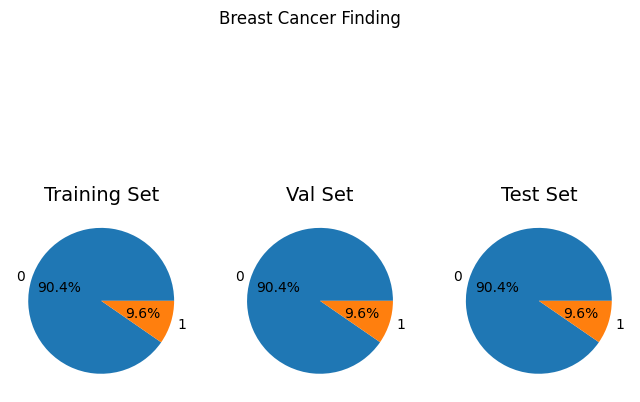

In [8]:
# label distributions
import matplotlib.pyplot as plt
value = train_df['label'].value_counts()
fig, axs = plt.subplots(1, 3, figsize=(8, 6))
fig.suptitle('Breast Cancer Finding')
axs[0].pie(value, labels=value.index, autopct='%1.1f%%')
axs[0].set_title('Training Set', fontsize=14)

# label distributions
value_1 = val_df['label'].value_counts()
axs[1].pie(value_1, labels=value_1.index, autopct='%1.1f%%')
axs[1].set_title('Val Set', fontsize=14)

# label distributions
value_2 = test_df['label'].value_counts()
axs[2].pie(value_2, labels=value_2.index, autopct='%1.1f%%')
axs[2].set_title('Test Set', fontsize=14)

plt.show()

In [9]:
img = cv2.imread('/kaggle/input/vinmammo-75-fullsize/png/png/0025a5dc99fd5c742026f0b2b030d3e9/2ddfad7286c2b016931ceccd1e2c7bbc.png')
print(img)

[[[143 143 143]
  [144 144 144]
  [153 153 153]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[146 146 146]
  [149 149 149]
  [150 150 150]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[145 145 145]
  [147 147 147]
  [156 156 156]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 ...

 [[ 26  26  26]
  [ 17  17  17]
  [ 11  11  11]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 27  27  27]
  [ 13  13  13]
  [  4   4   4]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]

 [[ 21  21  21]
  [  7   7   7]
  [  0   0   0]
  ...
  [  0   0   0]
  [  0   0   0]
  [  0   0   0]]]


## LOAD IMG

In [10]:
# !zip -r output.zip /kaggle/working
# from IPython.display import FileLink
# FileLink(r'output.zip')

In [11]:
img_size=(600,600)

train_datagen = ImageDataGenerator(
    rescale=1./255,
    rotation_range=20,
    zoom_range=0.2,
    horizontal_flip=True,
    fill_mode='nearest',)

train_generator = train_datagen.flow_from_dataframe(
    dataframe=train_df,
    x_col="image_path",
    y_col="label",
    target_size=img_size, 
    batch_size=16,
    class_mode="categorical",  
    shuffle=True
)

test_datagen = ImageDataGenerator()


val_generator = test_datagen.flow_from_dataframe(
    dataframe=val_df,
    x_col="image_path",
    y_col="label",
    target_size=img_size,  
    batch_size=4,
    class_mode="categorical",  
    shuffle=False  
)

test_generator = test_datagen.flow_from_dataframe(
    dataframe=test_df,
    x_col="image_path",
    y_col="label",
    target_size=img_size,  
    batch_size=4,
    class_mode="categorical",  
    shuffle=False  
)

Found 12004 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.
Found 2000 validated image filenames belonging to 2 classes.


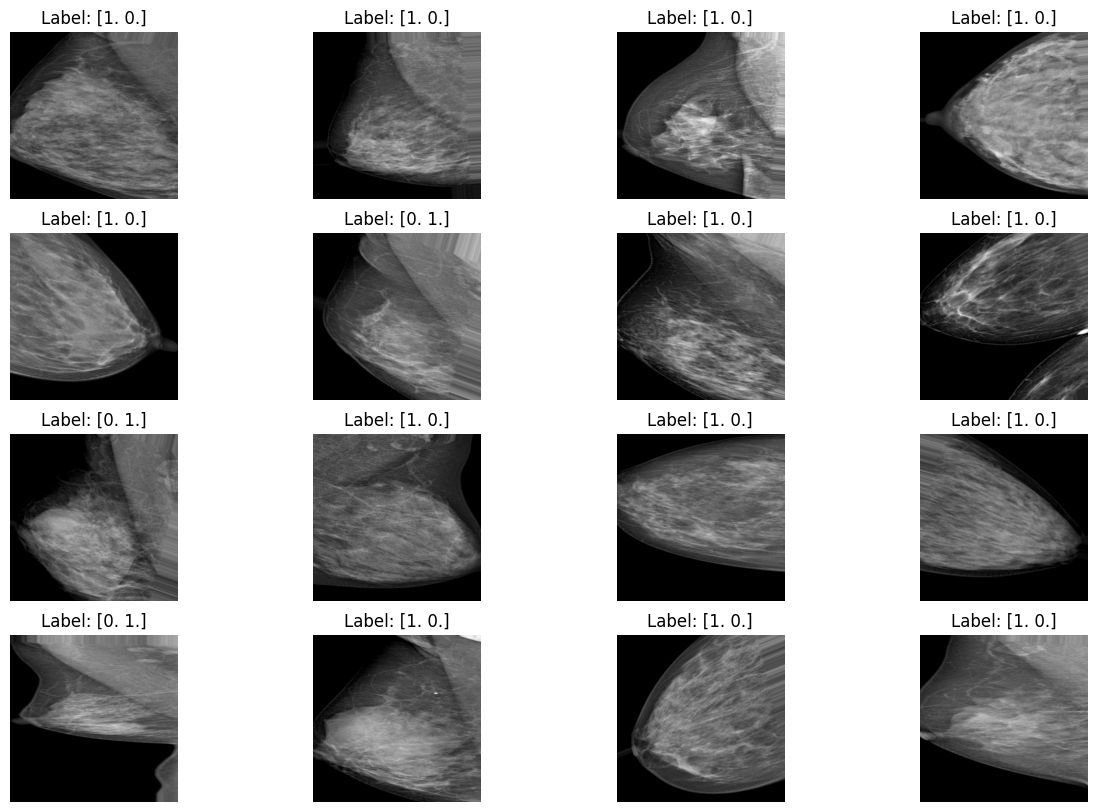

In [12]:
# Fetch a batch from the generator
sample_batch = train_generator[0]

# Extract the images and labels
combined_images, combined_labels = sample_batch

def reverse_preprocessing(image):
    return (image*255).astype(np.uint8) 

# Visualize a few sample images
num_samples = min(16, combined_images.shape[0])

plt.figure(figsize=(15, 10))
for i in range(num_samples):
    plt.subplot(4, 4, i + 1)
    plt.imshow(reverse_preprocessing(combined_images[i]))
    plt.title(f'Label: {combined_labels[i]}')
    plt.axis('off')

plt.show()

## TRAIN

In [13]:
class FocalLoss(tf.keras.losses.Loss):
    def __init__(self, alpha=0.25, gamma=2.0, from_logits=False, name='focal_loss'):
        super(FocalLoss, self).__init__(name=name)
        self.alpha = alpha
        self.gamma = gamma
        self.from_logits = from_logits

    def call(self, y_true, y_pred):
        if self.from_logits:
            y_pred = tf.nn.sigmoid(y_pred)

        epsilon = tf.keras.backend.epsilon()
        y_pred = tf.clip_by_value(y_pred, epsilon, 1.0 - epsilon)

        focal_loss = - self.alpha * tf.pow(1.0 - y_pred, self.gamma) * y_true * tf.math.log(y_pred) \
                     - (1.0 - self.alpha) * tf.pow(y_pred, self.gamma) * (1.0 - y_true) * tf.math.log(1.0 - y_pred)

        return tf.reduce_sum(focal_loss, axis=-1)

\[ \text{FL}(p_t) = -\alpha_t \cdot (1 - p_t)^\gamma \cdot \log(p_t) \]

    Where:
    - \( p_t \) is the predicted probability for the true class.
    - \( \alpha_t \) is a weight assigned to each class.
    - \( \gamma \) is a focusing parameter.

In [14]:
from tensorflow.keras.applications.densenet import DenseNet121
from tensorflow.keras.applications.efficientnet import EfficientNetB0
from tensorflow.keras.callbacks import LearningRateScheduler, EarlyStopping
from tensorflow.keras import layers
from tensorflow.keras.applications import EfficientNetB7
from tensorflow.keras.models import Sequential
from tensorflow.keras.metrics import F1Score, AUC
from tensorflow.keras.regularizers import l2
# import tensorflow_addons as tfa

input_shape = (600, 600, 3)

# Create the base model (EfficientNetB7)
base_model = EfficientNetB7(weights='imagenet', include_top=False, input_shape=input_shape)

# Freeze the base model layers
base_model.trainable = False

# Build the model
model = Sequential([
    base_model,
    layers.GlobalAveragePooling2D(),
    layers.Dense(2048, activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(1024, activation='relu', kernel_regularizer=l2(0.001)),
    layers.BatchNormalization(),
    layers.Dropout(0.5),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dense(512, activation='relu', kernel_regularizer=l2(0.001)),
    layers.Dense(2, activation='softmax')
])

model.summary()

258076736/258076736 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnetb7 (Functional  (None, 19, 19, 2560)      64097687  
 )                                                               
                                                                 
 global_average_pooling2d (  (None, 2560)              0         
 GlobalAveragePooling2D)                                         
                                                                 
 dense (Dense)               (None, 2048)              5244928   
                                                                 
 batch_normalization (Batch  (None, 2048)              8192      
 Normalization)                                                  
                                                                 
 dropout (Dropout)           (None, 2048)              

In [19]:
# optimizer = tfa.optimizers.RectifiedAdam(learning_rate=0.001)
# optimizer = tfa.optimizers.Lookahead(optimizer)

# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
              loss=FocalLoss(alpha=0.25, gamma=2.0, from_logits=False),
              metrics=['accuracy',
#                        F1Score(average='weighted', threshold=0.5, name='f1_score'), 
                       AUC(curve='PR', name='pr_auc')])

Personal note about the parameter in model compile:
- FocalLoss:
    + Alpha (alpha):
        * Purpose: Alpha is a weighting factor assigned to each class. It helps to balance the contribution of positive and negative samples during the computation of the loss.
        * Effect: A higher alpha gives more weight to the minority class (in your case, malignant mammograms), making the model more sensitive to the minority class. Conversely, a lower alpha reduces the emphasis on the minority class.
    + Gamma (gamma):
        * Purpose: Gamma controls the focusing parameter of the loss. It modulates how much the loss should focus on hard-to-classify examples (examples with low confidence).
        * Effect: A higher gamma increases the focusing effect, making the loss more sensitive to misclassified examples. This is particularly useful when dealing with a small number of hard-to-classify instances.
- F1Score:
    + Default Threshold (0.5):
        * Predictions with a probability greater than or equal to 0.5 are classified as the positive class (malignant in your case).
        * This threshold is a balanced point, but in imbalanced datasets, it may not prioritize the minority class effectively.
    + Lower Threshold (e.g., 0.3):
        * Predictions with a probability greater than or equal to 0.3 are classified as the positive class.
        * This lower threshold makes the model more sensitive to the malignant class, potentially increasing recall for the minority class.

In [20]:
from sklearn.metrics import f1_score

class F1ScoreCallback(tf.keras.callbacks.Callback):
    def __init__(self, num_classes=2, threshold=0.5):
        super(F1ScoreCallback, self).__init__()
        self.num_classes = num_classes
        self.threshold = threshold
        self.f1_score = 0.0

    def on_epoch_end(self, epoch, logs=None):
        y_true = self.validation_data[1].argmax(axis=1)
        y_pred = self.model.predict(self.validation_data[0]).argmax(axis=1)

        f1 = f1_score(y_true, y_pred, average='weighted')
        print(f'Weighted F1 Score: {f1}')

        if f1 > self.f1_score:
            self.f1_score = f1
            print('Saving model with improved F1 score...')
            self.model.save_weights('/kaggle/working/best_f1_model_weights.h5')
            
f1_score_callback = F1ScoreCallback()

es = EarlyStopping(monitor='val_auc_pr',
                   patience=10,
                   mode='max',
                   verbose=1,
                   restore_best_weights=True)

In [21]:
history = model.fit(train_generator,
                    validation_data=val_generator,
                    epochs=50, callbacks=[es])

Epoch 1/50


2024-03-03 14:15:42.247306: E tensorflow/core/grappler/optimizers/meta_optimizer.cc:961] layout failed: INVALID_ARGUMENT: Size of values 0 does not match size of permutation 4 @ fanin shape insequential/efficientnetb7/block1b_drop/dropout/SelectV2-2-TransposeNHWCToNCHW-LayoutOptimizer
I0000 00:00:1709475350.219602     101 device_compiler.h:186] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


751/751 [==============================] - 1420s 2s/step - loss: 1.7262 - accuracy: 0.8882 - pr_auc: 0.8715 - val_loss: 0.7174 - val_accuracy: 0.9040 - val_pr_auc: 0.8868
Epoch 2/50
751/751 [==============================] - 1249s 2s/step - loss: 0.3224 - accuracy: 0.9037 - pr_auc: 0.8826 - val_loss: 0.1972 - val_accuracy: 0.9040 - val_pr_auc: 0.8877
Epoch 3/50
751/751 [==============================] - 1254s 2s/step - loss: 0.1334 - accuracy: 0.9037 - pr_auc: 0.8789 - val_loss: 0.1052 - val_accuracy: 0.9040 - val_pr_auc: 0.8828
Epoch 4/50
751/751 [==============================] - 1247s 2s/step - loss: 0.0933 - accuracy: 0.9037 - pr_auc: 0.8794 - val_loss: 0.0871 - val_accuracy: 0.9040 - val_pr_auc: 0.8802
Epoch 5/50
751/751 [==============================] - 1247s 2s/step - loss: 0.0863 - accuracy: 0.9037 - pr_auc: 0.8820 - val_loss: 0.0858 - val_accuracy: 0.9040 - val_pr_auc: 0.8802
Epoch 6/50
751/751 [==============================] - 1255s 2s/step - loss: 0.0860 - accuracy: 0.9037

KeyboardInterrupt: 

In [22]:
loss_values = history.history['loss']
acc = history.history['accuracy']
f1 = history.history['f1_score']
prauc = history.history['pr_auc']

val_loss = history.history['val_loss']
val_acc = history.history['val_accuracy']
val_f1 = history.history['val_f1_score']
val_prauc = history.history['val_pr_auc']

epochs = range(1, len(acc) + 1)

plt.plot(epochs, loss_values, 'b', label='Loss')
plt.plot(epochs, val_loss, 'r', label='Val Loss')
plt.title('Loss', fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Val Accuracy')
plt.title('Accuracy', fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.plot(epochs, f1, 'b', label='Training F1 Score')
plt.plot(epochs, val_f1, 'r', label='Val F1 Score')
plt.title('F1', fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
plt.show()

plt.plot(epochs, prauc, 'b', label='Training Precision-Recall curve')
plt.plot(epochs, val_prauc, 'r', label='Val Precision-Recall curve')
plt.title('F1', fontsize=12)
plt.xlabel('Epochs')
plt.ylabel('F1')
plt.legend()
plt.show()

NameError: name 'history' is not defined

In [23]:
model.evaluate(test_generator)

500/500 [==============================] - 104s 208ms/step - loss: 0.0859 - accuracy: 0.9040 - pr_auc: 0.8802


[0.08586045354604721, 0.9039999842643738, 0.8801980018615723]

In [24]:
model.save('/kaggle/working/my_model.keras')

In [26]:
model.save_weights('/kaggle/working/my_model_weights.h5')

In [65]:
val_df.to_csv('/kaggle/working/val_df.csv', index=False)
test_df.to_csv('/kaggle/working/test_df.csv', index=False)

In [ ]:
zip -r output.zip /kaggle/working
from IPython.display import FileLink
FileLink(r'output.zip')

In [25]:
from sklearn.metrics import roc_auc_score

predictions = model.predict(test_generator)
true_labels = test_generator.classes

# Use roc_auc_score to compute AUC over multiple thresholds
roc_auc = roc_auc_score(true_labels, predictions[:, 1])
print(f"AUC: {roc_auc:.4f}")

500/500 [==============================] - 106s 203ms/step
AUC: 0.5000


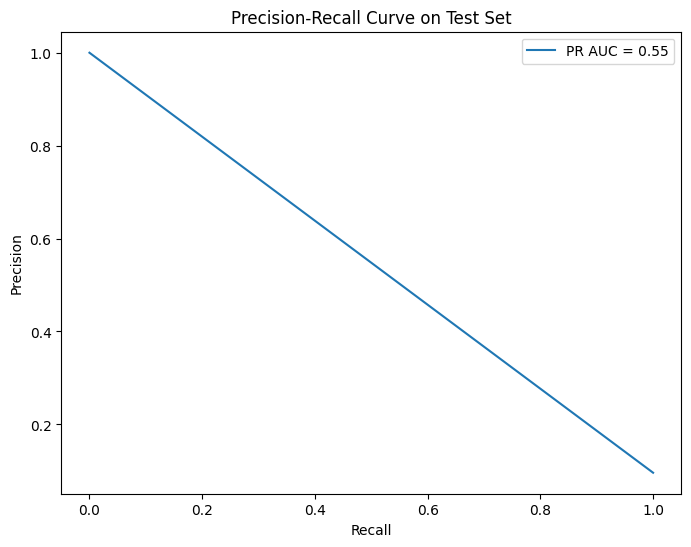

In [28]:
from sklearn.metrics import precision_recall_curve, auc
# Extract predicted probabilities for the positive class (class_1)
predicted_probs = predictions[:, 1]

# Calculate precision and recall values at various thresholds
precision, recall, thresholds = precision_recall_curve(true_labels, predicted_probs)

# Calculate area under the PR curve (PR AUC)
pr_auc = auc(recall, precision)

# Plot Precision-Recall Curve
plt.figure(figsize=(8, 6))
plt.plot(recall, precision, label=f'PR AUC = {pr_auc:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve on Test Set')
plt.legend()
plt.show()

In [64]:
import tensorflow as tf
import numpy as np

# Assuming you have predictions and true_labels
predictions = model.predict(test_generator)
true_labels = test_generator.classes

# Assuming the positive class is malignant (class 1)
positive_class_probs = predictions[:, 1]

# Convert to NumPy arrays
true_labels_np = np.array(true_labels)
positive_class_probs_np = positive_class_probs.astype(float)

# Use TensorFlow metrics
auc_metric = tf.keras.metrics.AUC(curve='PR')

# Update the metric using NumPy arrays
auc_metric.update_state(true_labels_np, positive_class_probs_np)

# Get the result
pr_auc_value = auc_metric.result().numpy()

print(f'PR AUC from TensorFlow: {pr_auc_value:.2f}')


500/500 [==============================] - 101s 202ms/step
PR AUC from TensorFlow: 0.10


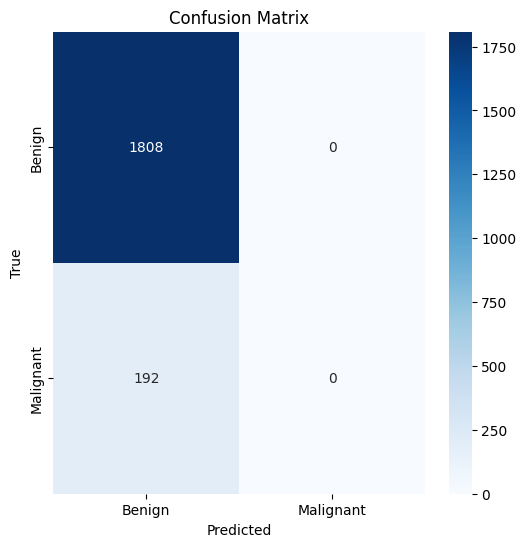

In [55]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming 'true_labels' and 'predicted_probs' are already defined
# true_labels: actual labels (0 for benign, 1 for malignant)
# predicted_probs: predicted probabilities for class 1 (malignant)

# Convert predicted probabilities to binary predictions using a threshold (e.g., 0.5)
threshold = 0.312599
predicted_labels = (predicted_probs > threshold).astype(int)

# Create a confusion matrix
cm = confusion_matrix(true_labels, predicted_labels)

# Plot the confusion matrix using seaborn
plt.figure(figsize=(6, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Benign', 'Malignant'], yticklabels=['Benign', 'Malignant'])
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

In [30]:
# Generate a classification report
report = classification_report(true_labels, predicted_labels, target_names=['Benign', 'Malignant'])

# Print the classification report
print(report)

              precision    recall  f1-score   support

      Benign       0.90      1.00      0.95      1808
   Malignant       0.00      0.00      0.00       192

    accuracy                           0.90      2000
   macro avg       0.45      0.50      0.47      2000
weighted avg       0.82      0.90      0.86      2000



/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/opt/conda/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
